<a href="https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics of Behavior Tutorial II - Part 5

In this session, we will focus on how to uncover long timescale properties from real behavioral data

Before we start, load the following python packages:

In [1]:
# Environment setup
!pip install -q -r https://raw.githubusercontent.com/AntonioCCosta/DPG_PhysicsBehavior_2026/main/requirements.txt

In [2]:

import os

if not os.path.exists("DPG_PhysicsBehavior_2026"):
    !git clone https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026.git
else:
    %cd DPG_PhysicsBehavior_2026
    !git pull
    %cd ..

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

/content/DPG_PhysicsBehavior_2026
Already up to date.
/content
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35


In [3]:
import h5py
import numpy as np
import numpy.ma as ma
sys.path.append('./DPG_PhysicsBehavior_2026/utils')
import operator_calculations as op_calc
import delay_embedding as embed
import partition_methods as cl
import coarse_graining as cgm
import matplotlib.pyplot as plt

# C. elegans foraging behavior

We will work with time series of body postures of C. elegans freely crawling on an agar plate.

In [4]:
def unwrapma(x):
    idx= ma.array(np.arange(0,x.shape[0]),mask=x.mask)
    idxc=idx.compressed()
    xc=x.compressed()
    dd=np.diff(xc)
    ddmod=np.mod(dd+np.pi,2*np.pi)-np.pi
    ddmod[(ddmod==-np.pi)&(dd>0)]=np.pi
    phc_correct = ddmod-dd
    phc_correct[np.abs(dd)<np.pi] = 0
    ph_correct = np.zeros(x.shape)
    ph_correct[idxc[1:]] = phc_correct
    up = x + ph_correct.cumsum()
    return up

from scipy.interpolate import CubicSpline

def compute_omega(tseries,t0,tf,frameRate=16.):
    time=np.arange(t0,tf)
    X=tseries[time]
    phi=-np.arctan2(X[:,1],X[:,0])
    cs = CubicSpline(time, phi)
    phiFilt=cs(time)
    phi_unwrap=unwrapma(phi)
    sel=~phi_unwrap.mask
    cs = CubicSpline(time[sel], phi_unwrap[sel])
    phiFilt_unwrap=cs(time[sel])
    omegaFilt=cs(time[sel],1)*frameRate/(2*np.pi)
    return omegaFilt

In [49]:
mat=h5py.File('./DPG_PhysicsBehavior_2026/data/PNAS2011-DataStitched.mat','r')
refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate
len_w,dim = tseries_w[0].shape


masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

tseries_all = ma.vstack(masked_ts_w)

segments=op_calc.segment_maskedArray(tseries_all,5)
omegas_all=ma.zeros(tseries_all.shape[0])
for t0,tf in segments:
    omegas_all[t0:tf] = compute_omega(tseries_all,t0,tf)
omegas_all[omegas_all==0]=ma.masked

eigenworms_matrix = np.loadtxt('./DPG_PhysicsBehavior_2026/data/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in masked_ts_w])
thetas_all = ma.vstack(thetas_w)
thetas_sum = thetas_all.sum(axis=1)

In [19]:
tseries_all.shape

(403200, 5)

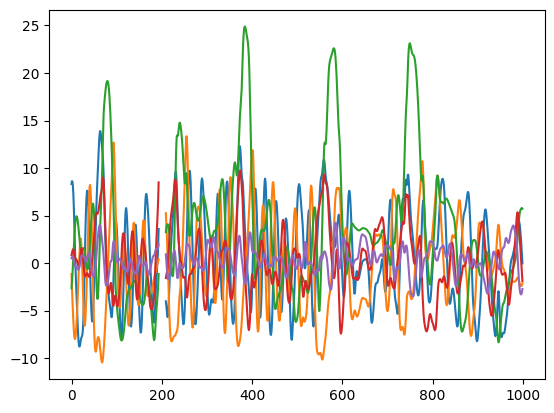

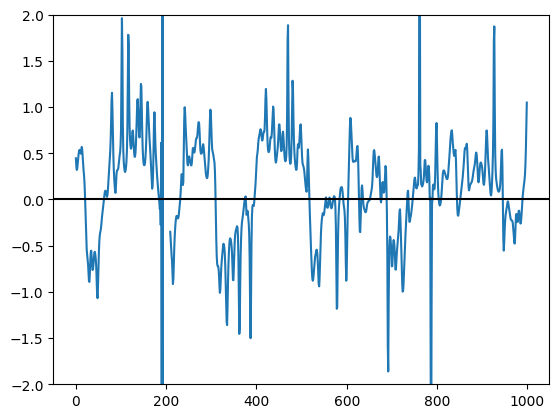

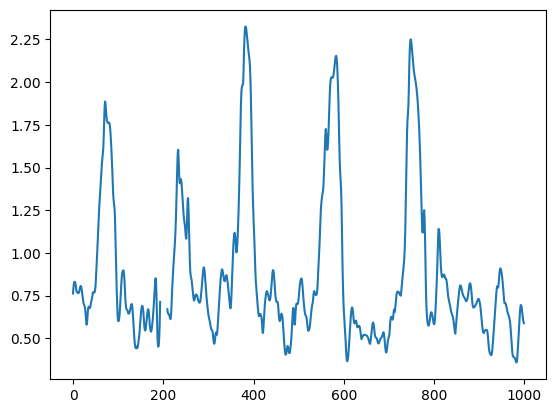

In [20]:
plt.plot(tseries_all[1000:2000])
plt.show()
plt.plot(omegas_all[1000:2000])
plt.ylim(-2,2)
plt.axhline(0,c='k')
plt.show()
plt.plot(curvature_all[1000:2000])
plt.show()

Now, as you've seen in the tutorial from Greg Stephens, we can reconstruct a topologically equivalent state space through including time delays. Here, we will examine an information theoretic way of thinking about reconstructing a state space by maximizing predictability. Here we will run the calculation for a single worm

In [21]:
from scipy.sparse import diags

example_tseries = masked_ts_w[0]

npartition_range=np.array(np.logspace(2,3.,4),dtype=int) #number of partitions to examine
range_Ks =  np.arange(1,15,1,dtype=int) #range of delays to study
h_K=np.zeros((len(range_Ks),len(npartition_range)))
Ipred_K=np.zeros((len(range_Ks),len(npartition_range)))
for k,K in enumerate(range_Ks):
    traj_matrix = embed.trajectory_matrix(example_tseries,K=K-1)
    print('created trajectory matrix of shape {}'.format(traj_matrix.shape))
    for kn,N in enumerate(npartition_range):
        labels=cl.kmeans_partition(traj_matrix,N,batchsize=5000)
        #estimate entropy rate
        P = op_calc.transition_matrix(labels,1)
        probs = op_calc.stationary_distribution(P)
        logP = P.copy()
        logP.data = np.log(logP.data)
        h = (-diags(probs).dot(P.multiply(logP))).sum()
        H = (-probs*np.log(probs)).sum()
        Ipred = H-h
        h_K[k,kn]=h
        Ipred_K[k,kn] = Ipred
        print('Computed for {} delays and {} partitions.'.format(K,N))

created trajectory matrix of shape (33600, 5)
Computed for 1 delays and 100 partitions.
Computed for 1 delays and 215 partitions.
Computed for 1 delays and 464 partitions.
Computed for 1 delays and 1000 partitions.
created trajectory matrix of shape (33600, 10)
Computed for 2 delays and 100 partitions.
Computed for 2 delays and 215 partitions.
Computed for 2 delays and 464 partitions.
Computed for 2 delays and 1000 partitions.
created trajectory matrix of shape (33600, 15)
Computed for 3 delays and 100 partitions.
Computed for 3 delays and 215 partitions.
Computed for 3 delays and 464 partitions.
Computed for 3 delays and 1000 partitions.
created trajectory matrix of shape (33600, 20)
Computed for 4 delays and 100 partitions.
Computed for 4 delays and 215 partitions.
Computed for 4 delays and 464 partitions.
Computed for 4 delays and 1000 partitions.
created trajectory matrix of shape (33600, 25)
Computed for 5 delays and 100 partitions.
Computed for 5 delays and 215 partitions.
Comput

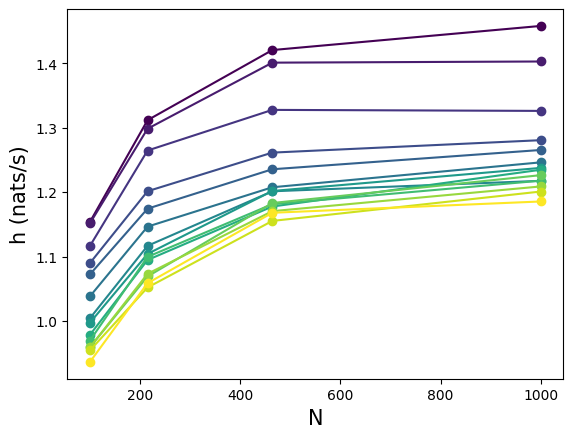

In [22]:
colors_K = plt.cm.viridis(np.linspace(0,1,len(range_Ks)))
for k,K in enumerate(range_Ks):
    plt.plot(npartition_range,h_K[k],c=colors_K[k],marker='o')
plt.xlabel('N',fontsize=15)
plt.ylabel('h (nats/s)',fontsize=15)
plt.show()

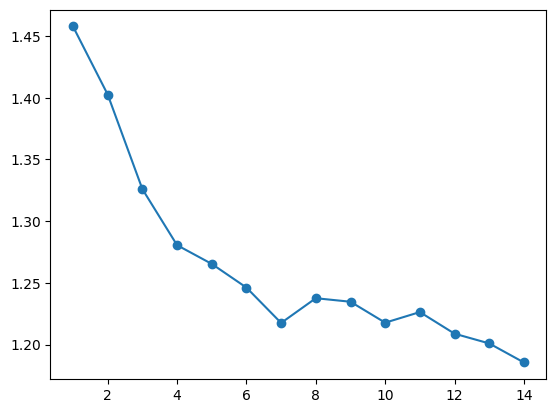

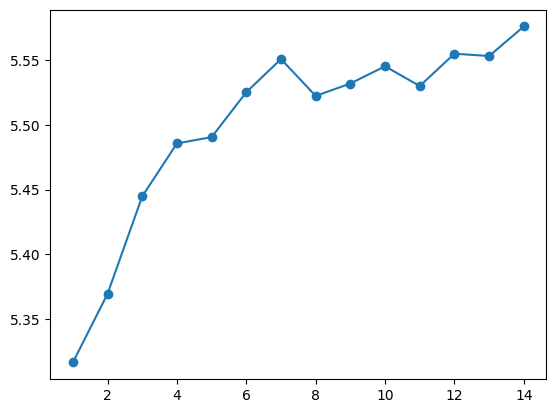

In [23]:
plt.plot(range_Ks,h_K[:,-1],marker='o')
plt.show()

plt.plot(range_Ks,Ipred_K[:,-1],marker='o')
plt.show()

In [25]:
K_star=11
traj_matrix = embed.trajectory_matrix(tseries_all,K=K_star-1)

In [38]:
n_neighbors=50;min_dist=.05
f = h5py.File('./DPG_PhysicsBehavior_2026/data/umap_n_{:.1f}_d_{:.2f}.h5'.format(n_neighbors,min_dist),'r')
u_all = ma.masked_invalid(f['umap'])
u_all[u_all==0] = ma.masked
f.close()
u = u_all[:-1000]
centers_umap = u_all[-1000:]

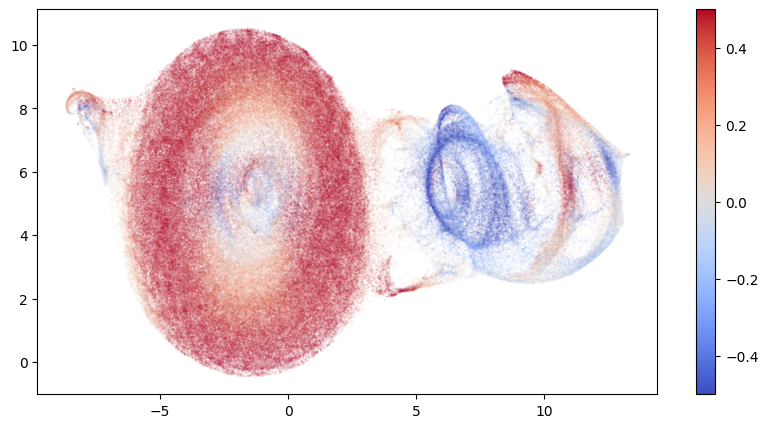

In [57]:
plt.figure(figsize=(10,5))
sel = ~omegas_all.mask
plt.scatter(u[sel,0],u[sel,1],c=omegas_all[sel],s=.001,cmap='coolwarm',vmax=.5,vmin=-.5)
plt.colorbar()
plt.show()

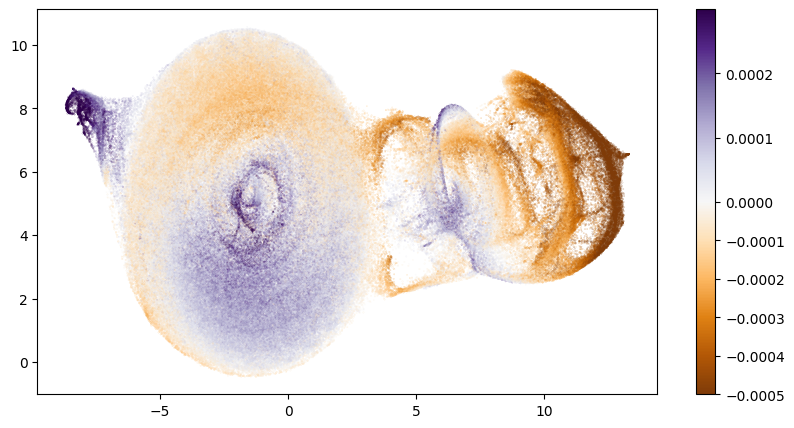

In [56]:
from matplotlib.colors import TwoSlopeNorm
sel = ~thetas_sum.mask
vmin,vmax=-5e-4,3e-4
plt.figure(figsize=(10,5))
plt.scatter(u[sel,0],u[sel,1],s=.01,norm=TwoSlopeNorm(vcenter=0,vmin=vmin,vmax=vmax),c=thetas_sum[sel],cmap='PuOr')
plt.colorbar()
plt.show()

Now that we have reconstructed the state space, let's use the Ulam-Galerkin method to approximate the transfer operator eigenvectors

In [27]:
N=1000
#labels_all is an array with the partition that each point in the time series belongs to
#centers is the centroid of each k-means cluster
labels_all,centers = cl.kmeans_partition(traj_matrix,N,batchsize=20000,return_centers=True)

In [32]:
delay_range = np.unique(np.array(np.logspace(0,2.5,100),dtype=int))
n_modes=5
eigvals_delay = np.zeros((len(delay_range),n_modes))
tscales_delay = np.zeros((len(delay_range),n_modes))
for kd,delay in enumerate(delay_range):
  P_emp = op_calc.transition_matrix(labels_all,delay)
  R = op_calc.get_reversible_transition_matrix(P_emp)
  eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(R,k=n_modes+1)
  timps=-delay*dt/np.log(eigvals_emp[1:].real)
  tscales_delay[kd] = timps
  eigvals_delay[kd] = eigvals_emp[1:].real
  print(delay)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
23
24
25
27
29
30
32
34
36
38
41
43
46
49
52
55
58
62
65
69
73
78
83
87
93
98
104
111
117
124
132
140
148
157
166
176
187
198
210
223
236
250
265
281
298
316


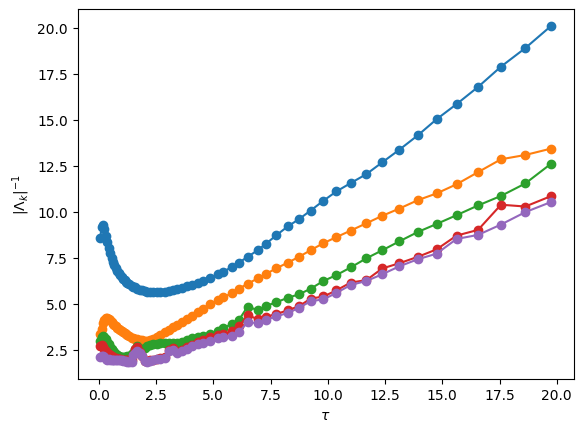

In [33]:
plt.plot(delay_range*dt,tscales_delay,marker='o')
plt.ylabel(r'$|\Lambda_k|^{-1}$')
plt.xlabel(r'$\tau$')
plt.show()

In [58]:
delay=24
P_emp = op_calc.transition_matrix(labels_all,delay)
R = op_calc.get_reversible_transition_matrix(P_emp)
eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(R,k=5)
eigvecs_emp = eigvecs_emp.real
eigvecs_emp = eigvecs_emp/np.linalg.norm(eigvecs_emp,axis=0)
phi2_emp = eigvecs_emp[:,1]

In [68]:
phi2_traj = ma.masked_invalid(phi2_emp)[labels_all]
phi2_traj[labels_all.mask]=ma.masked

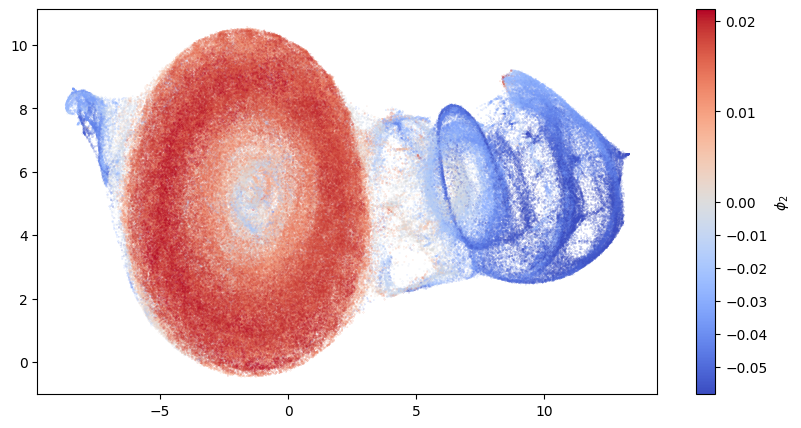

In [75]:
from matplotlib.colors import TwoSlopeNorm
sel = ~phi2_traj.mask
vmin,vmax=np.percentile(phi2_traj.compressed(),2.5),np.percentile(phi2_traj.compressed(),97.5)
plt.figure(figsize=(10,5))
plt.scatter(u[sel,0],u[sel,1],s=.01,norm=TwoSlopeNorm(vcenter=0,vmin=vmin,vmax=vmax),c=phi2_traj[sel],cmap='coolwarm')
plt.colorbar(label=r'$\phi_2$')
plt.show()

As before, we can identify discrete behavioral states by searching for a separation along $\phi_2$

In [76]:
inv_measure_emp = op_calc.stationary_distribution(P_emp)
cr,rho_sets,ms,idx,km_labels = cgm.optimal_partition(phi2_emp,inv_measure_emp,P_emp,return_rho=True)

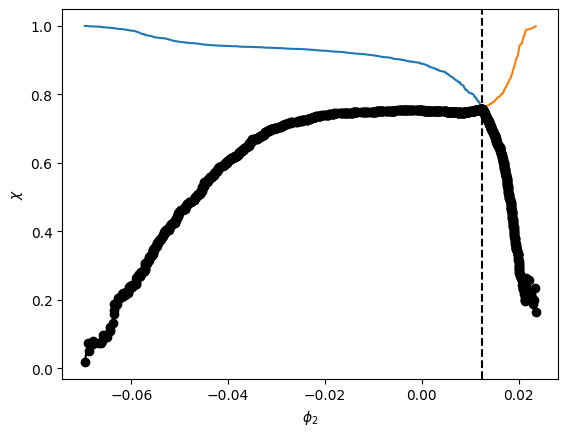

In [77]:
plt.plot(cr,rho_sets)
plt.plot(cr,np.min(rho_sets,axis=1),marker='o',c='k')
plt.axvline(cr[idx],c='k',ls='--')
plt.ylabel(r'$\chi$')
plt.xlabel(r'$\phi_2$')
plt.show()

In [78]:
distorted_phis,_ = cgm.get_distorted_eigfs(P_emp,2,tau=delay,dt=dt,commute=False)

1
2


In [79]:
dphis_traj = ma.masked_invalid(distorted_phis[:,0])[labels_all]
dphis_traj[labels_all.mask]=ma.masked

In [80]:
dphis_traj

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20)

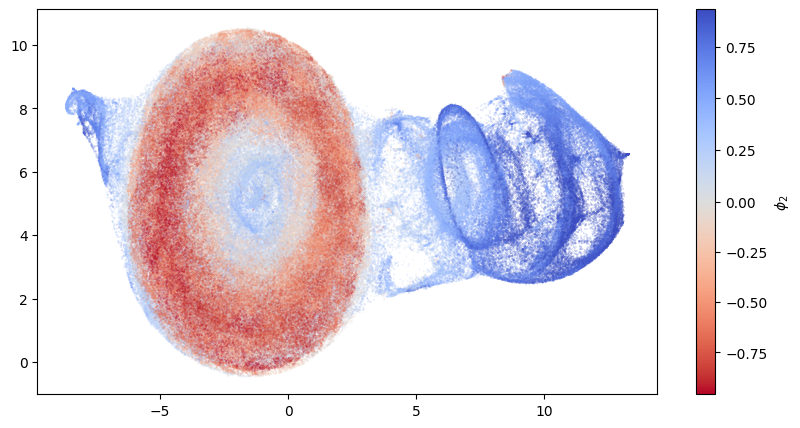

In [84]:
from matplotlib.colors import TwoSlopeNorm
sel = ~dphis_traj.mask
vmin,vmax=np.percentile(dphis_traj.compressed(),2.5),np.percentile(dphis_traj.compressed(),97.5)
plt.figure(figsize=(10,5))
plt.scatter(u[sel,0],u[sel,1],s=.01,norm=TwoSlopeNorm(vcenter=0,vmin=vmin,vmax=vmax),c=dphis_traj[sel],cmap='coolwarm_r')
plt.colorbar(label=r'$\phi_2$')
plt.show()

So we find a slow mode that captures the transitions among run and pirouette behaviors

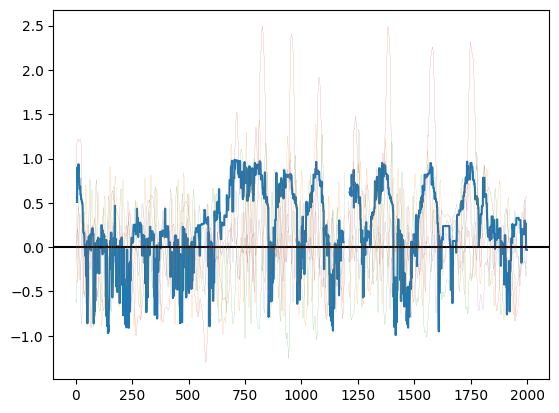

In [89]:
plt.plot(dphis_traj[:2000])
plt.axhline(0,c='k')
plt.plot(tseries_all[:2000]/10,lw=.1)
plt.show()